# multidms

## Overview of model

The `multidms` model applies to a case where you have DMS datasets for two or more homologs and are interested in identifying shifts in mutational effects between homologs.
To do so, the model defines one homolog as a reference homolog.
For each mutation, the model fits one parameter that quantifies the effect of the mutation in the reference homolog.
For each non-reference homolog, it also fits a shift parameter that quantifies the shift in the mutation's effect in the non-reference homolog relative to the reference.
Shift parameters can be regularized, encouraging most of them to be close to zero.
This regularization step is a useful way to eliminate the effects of experimental noise, and is most useful in cases where you expect most mutations to have the same effects between homologs, such as for homologs that are close relatives.

The model uses a global-epistasis function to disentangle the effects of multiple mutations on the same variant.
To do so, it assumes that mutational effects additively influence a latent biophysical property the protein (e.g., $\Delta G$ of folding).
The mutational-effect parameters described above operate at this latent level.
The global-epistasis function then assumes a sigmoidal relationship between a protein's latent property and its functional score measured in the experiment (e.g., log enrichment score).
Ultimately, mutational parameters, as well as ones controlling the shape of the sigmoid, are all jointly fit to maximize agreement between predicted and observed functional scores acorss all variants of all homologs.

## Detailed description of the model

For each variant $v$ from homolog $h$, we use a global-epistasis function $g$ to convert a latent phenotype $\phi$ to a functional score $f$:

$$f(v,h) = g_{\alpha}(\phi(v,h))$$

where $g$ is a sigmoid and $\alpha$ is a set of parameters encoding the sigmoid.

The latent phenotype is computed in the following way:

$$\phi(v,h) = c + \sum_{m \in v} (x_m + s_{m,h})$$

where:
* $c$ is the wildtype latent phenotype for the reference homolog.
* $x_m$ is the latent phenotypic effect of mutation $m$. See details below.
* $s_{m,h}$ is the shift of the effect of mutation $m$ in homolog $h$. These parameters are fixed to zero for the reference homolog. For non-reference homologs, they are defined in the same way as $x_m$ parameters.
* $v$ is the set of all mutations relative to the reference wildtype sequence (including all mutations that separate homolog $h$ from the reference homolog).

The $x_m$ variable is defined such that mutations are always relative to the reference homolog.
For example, if the wildtype amino acid at site 30 is an A in the reference homolog, and a G in a non-reference homolog, then a Y30G mutation in the non-reference homolog is recorded as an A30G mutation relative to the reference.
This way, each homolog informs the exact same parameters, even at sites that differ in wildtype amino acid.
These are encoded in a `BinaryMap` object, where all sites that are non-identical to the reference are 1's.

Ultimately, we fit parameters using a loss function with one term that scores differences between predicted and observed values and another that uses L1 regularization to penalize non-zero $s_{m,h}$ values:

$$ L_{\text{total}} = \sum_{h} \left[\sum_{v} L_{\text{fit}}(y_{v,h}, f(v,h)) + \lambda \sum_{m} |s_{m,h}|\right]$$

where:
* $L_{\text{total}}$ is the total loss function.
* $L_{\text{fit}}$ is a loss function that penalizes differences in predicted vs. observed functional scores.
* $y_{v,h}$ is the experimentally measured functional score of variant $v$ from homolog $h$.

## Model using matrix algebra

We compute a vector or predicted latent phenotypes $P_{h}$ as:

$$P_{h} = c + (X_h \cdot (β + S_h))$$

where:
* $β$ is a vector of all $β_m$ values.
* $S_h$ is a matrix of all $s_{m,h}$ values.
* $X_h$ is a sparse matrix, where rows are variants, columns are mutations (all defined relative to the reference homolog), and values are weights of 0's and 1's. These weights are used to compute the phenotype of each variant given the mutations present.
* $c$ is the same as above.

In the matrix algebra, the sum of $β_m$ and $S_{m,h}$ gives a vector of mutational effects, with one entry per mutation.
Multiplying the matrix $X_h$ by this vector gives a new vector with one entry per variant, where values are the sum of mutational effects, weighted by the variant-specific weights in $X_h$.
Adding the $c$ value to this vector will give a vector of predicted latent phenotypes for each variant.

Next, the global-epistasis function can be used to convert a vector of predicted latent phenotypes to a vector of predicted functional scores.

$$F_{h,pred} = g_{\alpha}(P_h)$$

Finally, this vector could be fed into a loss function and compared with a vector of observed functional scores.

## Import `Python` modules

In [61]:
import pandas as pd
# import numpy as np
import re
import json
import binarymap as bmap
import matplotlib.pyplot as plt
import seaborn as sns
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.experimental import sparse
import jaxopt
import numpy as onp
from scipy.stats import pearsonr

## Strategy for converting mutations to be relative to the reference homolog

As described above, our strategy involves converting all mutations in all homologs to be relative to the amino-acid sequence of the reference homolog. The below function performs this step.

Note 1: we will probably need some special-purpose code to handle gaps. This isn't done yet.

In [82]:
def create_homolog_modeling_data(
    func_score_df:pd.DataFrame, 
    homologs:dict,
    homolog_name_col: str,
    substitution_col: str,
    func_score_col: str
):
    """
    Takes a dataframe for making a `BinaryMap` object, and adds
    a column where each entry is a list of mutations in a variant
    relative to the amino-acid sequence of the reference homolog.
    
    Parameters
    ----------

    func_score_df : pandas.DataFrame
        This should be in the same format as described in BinaryMap.
        
    homologs : dict
        A dictionary containing all possible target homolog 
        names (keys) and sequences (values).
    
    homolog_name_col : str
        The name of the column in func_score_df that identifies the
        homolog for a given variant. We require that the
        reference homolog variants are labeled as 'reference'
        in this column.
    
    substitution_col : str 
        The name of the column in func_score_df that
        lists mutations in each variant relative to the wildtype
        amino-acid sequence of the homolog in which they occur.
        
    func_score_col : str
        Column in func_scores_df giving functional score for each variant.
    
    Returns
    -------
        
    TODO
    
    """
    
    def mutations_wrt_ref(mutations, hom_wtseq):
        """
        Takes a list of mutations for a given variant relative
        to its background homolog and returns a list of all
        mutations that separate the variant from the reference
        homolog.
        """
        
        # Compute the full amino-acid sequence of the
        # given variant
        mutated_homolog = list(hom_wtseq)
        for mutation in mutations.split():

            # TODO: Do we need to change the regex to allow
            # for gap '-' and stop '*' characters?
            pattern = r'(?P<aawt>\w)(?P<site>\d+)(?P<aamut>[\w\*])'
            match = re.search(pattern, mutation)
            assert match != None, mutation
            aawt = match.group('aawt')
            site = match.group('site')
            aamut = match.group('aamut')
            mutated_homolog[int(site)-1] = aamut
            
        hom_var_seq = ''.join(mutated_homolog)
        
        # Make a list of all mutations that separate the variant
        # from the reference homolog
        ref_muts = [
            f"{aaref}{i+1}{aavar}" 
            for i, (aaref, aavar) in enumerate(zip(homologs["reference"], hom_var_seq))
            if aaref != aavar
        ]
        
        return " ".join(ref_muts)

    # Duplicate the substitutions_col, then convert the respective functional scores
    func_score_df = func_score_df.assign(var_wrt_ref = func_score_df[substitution_col].values)
    for hom_name, hom_seq in homologs.items():
        if hom_name == "reference": continue
        hom_df = func_score_df.query(f"{homolog_name_col} == '{hom_name}'")
        hom_var_wrt_ref = [
            mutations_wrt_ref(muts, homologs[hom_name]) 
            for muts in hom_df[substitution_col]
        ]
        func_score_df.loc[hom_df.index.values, "var_wrt_ref"] = hom_var_wrt_ref   
    
    # Get list of all allowed substitutions that we will tune beta parameters for
    allowed_subs = {
        s for subs in func_score_df.var_wrt_ref
        for s in subs.split()
    }
    
    # Make BinaryMap representations for each homolog
    X, y = {}, {}
    for homolog, homolog_func_score_df in func_score_df.groupby("homolog"):
        
        ref_bmap = bmap.BinaryMap(
            homolog_func_score_df,
            substitutions_col="var_wrt_ref",
            allowed_subs=allowed_subs
        )
        
        # convert binarymaps into sparse arrays for model input
        X[homolog] = sparse.BCOO.fromdense(ref_bmap.binary_variants.toarray())
        assert onp.all(X[homolog].todense() == ref_bmap.binary_variants.toarray())
        
        
        # create jax array for functional score targets
        y[homolog] = jnp.array(func_score_df[func_score_col].values)
    
    return (X, y), func_score_df, ref_bmap.all_subs


Next, we will test the above function with a small test case. Below, we define variants from two imaginary homologs: "reference" and "2".

In [83]:
homologs = {
    "reference" : "MG",
    "2" : "MP"
}

In [84]:
test_dict = {
    'homolog' : ["reference","reference","reference","2","2","2","2","2"],
    'variant' : ['M1E', 'G2R', 'G2P', 'M1E', 'P2R', 'P2G', 'M1E P2G', 'M1E P2R'],
    'log2E' : [2, -7, -0.5, 2.3, -5, 0.4, 2.7, -2.7],
}
test_df = pd.DataFrame(test_dict)
test_df

,homolog,variant,log2E
0,reference,M1E,2.0
1,reference,G2R,-7.0
2,reference,G2P,-0.5
3,2,M1E,2.3
4,2,P2R,-5.0
5,2,P2G,0.4
6,2,M1E P2G,2.7
7,2,M1E P2R,-2.7


In [85]:
(X, y), updated_func_score_df, all_subs = create_homolog_modeling_data(test_df, homologs, "homolog", "variant", "log2E")

# print(f"Modeling Input Data: {X}")
# print(f"Modeling Target Data: {y}")

updated_func_score_df

,homolog,variant,log2E,var_wrt_ref
0,reference,M1E,2.0,M1E
1,reference,G2R,-7.0,G2R
2,reference,G2P,-0.5,G2P
3,2,M1E,2.3,M1E G2P
4,2,P2R,-5.0,G2R
5,2,P2G,0.4,
6,2,M1E P2G,2.7,M1E
7,2,M1E P2R,-2.7,M1E G2R


## Implementing the full model with JAX

Below, we implement the $\phi$ and $g$ functions from above.

Next, we initialize values of free parameters for downstream optimization by JAX.

In [86]:
def initialize_model_params(homologs: dict, n_beta_shift_params: int, n_perceptron_units=1):
    """
    initialize a set of starting parameters for the JAX model.
    
    Parameters
    ----------
    
    homologs : dict
        A dictionary containing all possible target homolog 
        names (keys) and sequences (values).
    
    n_beta_shift_params: int
        The number of beta and shift parameters 
        (for each homolog) to initialize.
        
    n_perceptron_units : int
        The number of connections that are tuned
        for the shape of global epistasis before
        being fed into a sigmoid.
    
    Returns
    -------
    
    dict :
        all relevant parameters to be tuned with the JAX model.
    """
    
    params = {}
    seed = 0
    key = jax.random.PRNGKey(seed)

    # initialize beta parameters from normal distribution.
    params["β"] = jax.random.normal(shape=(n_beta_shift_params,), key=key)

    # initialize shift parameters
    for homolog in homologs.keys():
        # We expect most shift parameters to be close to zero
        params[f"S_{homolog}"] = jnp.zeros(shape=(n_beta_shift_params,))

    # Single bias param
    params["C_ref"] = jnp.zeros(shape=(1, ))
    
    # 'stretch' in x direction
    # 'shift' in the x direction
    # 'stretch' in the y direction
    # 'shift' in the y direction
    key, *subkeys = jax.random.split(key, num=5)
    params["α"]=dict(
        sig_stretch_x = jax.random.normal(shape=(n_perceptron_units,), key=subkeys[0]),
        sig_shift_x = jax.random.normal(shape=(1,), key=subkeys[1]),
        sig_stretch_y = jax.random.normal(shape=(n_perceptron_units,), key=subkeys[2]),
        sig_shift_y = jax.random.normal(shape=(1,), key=subkeys[3]),
    )

    return params

In [87]:
# number of columns in the sparse arrays are the number of beta/shift params to fit
params = initialize_model_params(homologs, n_beta_shift_params = X["reference"].shape[1])
params

{'β': DeviceArray([ 0.18784401, -1.28334229,  0.6494182 ], dtype=float64),
 'S_reference': DeviceArray([0., 0., 0.], dtype=float64),
 'S_2': DeviceArray([0., 0., 0.], dtype=float64),
 'C_ref': DeviceArray([0.], dtype=float64),
 'α': {'sig_stretch_x': DeviceArray([-1.31768732], dtype=float64),
  'sig_shift_x': DeviceArray([0.44991238], dtype=float64),
  'sig_stretch_y': DeviceArray([0.47178911], dtype=float64),
  'sig_shift_y': DeviceArray([-0.94836575], dtype=float64)}}

Define an objective function to optimize

In [88]:
# TODO centering wildtype -
# TODO static args for reference -
# TODO regularization -
# TODO clip the α, parameters above 0
# TODO use whole dataset
# When looking at the data, separate 
# for evaluating the sigmoid, look at the simulation.

@jax.jit
def ϕ(params:dict, X_h:jnp.array):
    """ Model for predicting latent space """
    
    return (X_h @ (params["β"] + params[f"S"])) + params["C_ref"]


@jax.jit
def g(α:dict, z_h:jnp.array):
    """ Model for global epistasis as 'flexible' sigmoid. """
     
    activations = jax.nn.sigmoid(α["sig_stretch_x"] * z_h[:, None] + α["sig_shift_x"])
#     wt_activations = jax.nn.sigmoid(α["sig_stretch_x"] * α["C_ref"] + α["sig_shift_x"])
#     activations -= wt_activations
    return (α["sig_stretch_y"] * activations) + α["sig_shift_y"] # sig shift y needs to be 0 for the reference


@jax.jit
def cost_smooth(params, data, δ=1):
    """Cost (Objective) function as a sum of huber loss across all homologs"""
    # TODO : We could probably use f(), here

    X, y = data
    loss = 0   
    
    # Sum the huber loss across all homologs
    for homolog, X_h in X.items():
        
        # Fix the shift parameters for reference to 0
        # Static arguments for reference params?
        S_h = jnp.where(
            homolog=="reference", 
            jnp.zeros(len(params['β'])), 
            params[f"S_{homolog}"]
        )
        
        # Subset the params being passed into latent prediction, ϕ
        h_params = {"β":params["β"], "S":S_h, "C_ref":params["C_ref"]}
        
        z_h = ϕ(h_params, X_h)
        
        # TODO clip α params
        
        
        # Pass the latent predictions through GE model prediction
        # all GE specific parameters are stored in α
        y_h_predicted = g(params["α"], z_h)
        
        # compute loss at current parameter state.
        loss += jaxopt.loss.huber_loss(y[homolog], y_h_predicted, δ).mean()

    return loss

Calculate initial loss with random parameters

In [89]:
cost_smooth(params, (X, y))

DeviceArray(4.82309878, dtype=float64)

In [90]:
tol = 1e-6
maxiter = 1000
solver = jaxopt.GradientDescent(cost_smooth, tol=tol, maxiter=maxiter)

Optimize the entire model at once with gradient decent

In [91]:
params, state = solver.run(params, data=(X, y))
params

{'C_ref': DeviceArray([-0.41645006], dtype=float64),
 'S_2': DeviceArray([-0.08995514,  0.06204292, -0.22570208], dtype=float64),
 'S_reference': DeviceArray([0., 0., 0.], dtype=float64),
 'α': {'sig_shift_x': DeviceArray([0.79438156], dtype=float64),
  'sig_shift_y': DeviceArray([-0.05026768], dtype=float64),
  'sig_stretch_x': DeviceArray([-1.02919693], dtype=float64),
  'sig_stretch_y': DeviceArray([0.00032971], dtype=float64)},
 'β': DeviceArray([ 0.02419704, -1.12096377,  0.19726752], dtype=float64)}

## Simulation Fit

* TODO J: Try removing for loop in cost function (only compute cost on homolog)

* TODO H: Get will's notebook running in our environment (positive control for env)

* TODO J: jnp where culprit:
    * Try removing the shift parameters & update Phi accordingly
    * static args for reference

* TODO H: Run the Ab-CGGnaive_DMS with our model
* TODO H: Smaller simulated sequence

In [92]:
simulated_dataset = pd.read_csv("../results/simulated_dataset_v1.csv")
simulated_dataset_lib1 = simulated_dataset.query("library == 'lib_1'").copy()
simulated_dataset_lib1.aa_substitutions.fillna("", inplace=True)
simulated_dataset_lib1 = simulated_dataset_lib1.sample(n=15000, random_state=23)

In [93]:
homologs = json.load(open("../results/homolog_aa_seqs.json", "r"))
homologs["reference"] = homologs['1']
homologs["H2"] = homologs['2']
del homologs['1']
del homologs['2']
homologs

{'reference': 'RSVILRAYTNSRVKRVILCNNDLPIRNIRLMMILHNSDASFSTPVGLRSG',
 'H2': 'RVVILRAYTNSRVKRIKLCNNDRPIRNIRTMMIEHNSDAKFHTPYGLDSG'}

In [94]:
(X, y), updated_sim_func_score_df, all_subs = create_homolog_modeling_data(
                            simulated_dataset_lib1, 
                            homologs, 
                            "homolog", 
                            "aa_substitutions",
                            "observed_phenotype"
                        )
print(f"Modeling Input Data: {X}")
print(f"Modeling Target Data: {y}")

updated_sim_func_score_df

Modeling Input Data: {'H2': BCOO(int8[7453, 1000], nse=85747), 'reference': BCOO(int8[7547, 1000], nse=14483)}
Modeling Target Data: {'H2': DeviceArray([-8.73285355e-04, -5.66241131e+00, -9.96578409e+00, ...,
              0.00000000e+00, -9.96464844e+00, -9.96184311e+00],            dtype=float64), 'reference': DeviceArray([-8.73285355e-04, -5.66241131e+00, -9.96578409e+00, ...,
              0.00000000e+00, -9.96464844e+00, -9.96184311e+00],            dtype=float64)}


,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment,homolog,var_wrt_ref
74466,lib_1,TTGGCGACCCGAACAA,3,GTG13AAC,V13N,1,1,5.458805,-0.000873,0.999395,H2,S2V V13N V16I I17K L23R L30T L34E S40K S42H V4...
11621,lib_1,CTCTGGCATGTATCCG,1,CTG5GTG ATC17TGT TGC19CAG CAC35CTC,L5V I17C C19Q H35L,4,4,-3.963761,-5.662411,0.019744,reference,L5V I17C C19Q H35L
64058,lib_1,GATTTGCGGTACCTGA,1,GTA2GGA AAG17CAG AAC21TTC GAA34TTT,V2G K17Q N21F E34F,4,4,-22.730849,-9.965784,0.001000,H2,S2G V16I I17Q N21F L23R L30T L34F S40K S42H V4...
10033,lib_1,CGCTTATGGTATGGAG,1,TCC2CTT ACC9TTT CTA34GAT GTA45GTT,S2L T9F L34D,4,3,-18.845664,-9.965775,0.001000,reference,S2L T9F L34D
22076,lib_1,TGAGACCTCTGCAATT,2,AAC27TCG,N27S,1,1,-3.777811,-5.411847,0.023489,reference,N27S
...,...,...,...,...,...,...,...,...,...,...,...,...
60962,lib_1,CTACCGGTACTAAGTC,3,CGT6CCA GGT46GCC,R6P G46A,2,2,-12.318371,-9.959334,0.001004,H2,S2V R6P V16I I17K L23R L30T L34E S40K S42H V45...
1710,lib_1,ACAATACGTGGTGCCC,3,GTG13GCT CGC26AGT,V13A R26S,2,2,-0.423700,-1.325904,0.398899,reference,V13A R26S
62523,lib_1,GAAACACTCTGCGTGG,1,NaN,,0,0,5.612939,0.000000,1.000000,H2,S2V V16I I17K L23R L30T L34E S40K S42H V45Y R48D
14167,lib_1,GCAATTTAAGAAGTCT,1,ATT4TAC GTA16ATT AAC27AGT TCA49GCC,I4Y V16I N27S S49A,4,4,-14.059964,-9.964648,0.001001,reference,I4Y V16I N27S S49A


In [37]:
# number of columns in the sparse arrays are the number of beta/shift params to fit
params = initialize_model_params(homologs, n_beta_shift_params = X["reference"].shape[1])

In [38]:
for key, value in params.items():
    if key == "α":
        for key_a, value_a in value.items():
            print(f"Parameter {key_a} has shape: {value_a.shape}")        
    else:
        print(f"Parameter {key} has shape: {value.shape}")

Parameter β has shape: (1000,)
Parameter S_reference has shape: (1000,)
Parameter S_H2 has shape: (1000,)
Parameter C_ref has shape: (1,)
Parameter sig_stretch_x has shape: (1,)
Parameter sig_shift_x has shape: (1,)
Parameter sig_stretch_y has shape: (1,)
Parameter sig_shift_y has shape: (1,)


In [39]:
cost_smooth(params, (X, y))

DeviceArray(8.18398931, dtype=float64)

In [40]:
tol = 1e-6
maxiter = 20
solver = jaxopt.GradientDescent(cost_smooth, tol=tol, maxiter=maxiter)

In [41]:
params, state = solver.run(params, data=(X, y))

In [42]:
# print(f"Full model optimization: {state.iter_num} iterations, error = {state.error:.2e}, cost = {cost_smooth(params, (X, y)):.2e}")

In [43]:
print(f"Full model optimization: {state.iter_num} iterations")
print(f"error = {state.error:.2e}")
print(f"cost = {cost_smooth(params, (X, y)):.2e}")
# print(f"Wall time for fit: {end - start}")

Full model optimization: 20 iterations
error = 4.92e-04
cost = 7.39e+00


Looks like its fitting, time to look at some of the results

In [22]:
updated_sim_func_score_df["latent_predicted"] = onp.nan
updated_sim_func_score_df["observed_predicted"] = onp.nan

# Sum the huber loss across all homologs
# for homolog, X_h in X.items():
for homolog, hdf in updated_sim_func_score_df.groupby("homolog"):

    # Subset the params being passed into latent prediction, ϕ
    h_params = {"β":params["β"], "S":params[f"S_{homolog}"], "C_ref":params["C_ref"]}
    z_h = ϕ(h_params, X[homolog])
    updated_sim_func_score_df.loc[hdf.index, "latent_predicted"] = z_h
    
    # Pass the latent predictions through GE model prediction
    # all GE specific parameters are stored in α
    y_h_pred = g(params["α"], z_h)
    updated_sim_func_score_df.loc[hdf.index, "observed_predicted"] = y_h_pred

updated_sim_func_score_df

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment,homolog,var_wrt_ref,latent_predicted,observed_predicted
56683,lib_1,CACATTCAATGAAATC,2,TTT41GAC,F41D,1,1,6.735094,0.003540,1.002456,H2,S2V V16I I17K L23R L30T L34E S40K F41D S42H V4...,-0.907620,-4.153789
923,lib_1,AAGATCCTTTGAAGGC,1,GCT7CGT CAC35CGT,A7R H35R,2,2,-11.393292,-9.949523,0.001011,reference,A7R H35R,-1.414122,-4.146901
12019,lib_1,CTGTCAAATGTAGCAA,2,CGG12GTC ATC28AAA,R12V I28K,2,2,5.534886,0.004002,1.002778,reference,R12V I28K,2.468092,-4.220401
71324,lib_1,TCGGACGCTGATTCCA,2,NaN,,0,0,5.612939,0.000000,1.000000,H2,S2V V16I I17K L23R L30T L34E S40K S42H V45Y R48D,0.234303,-4.178294
11022,lib_1,CTAGAAGCCAGGAGAG,3,NaN,,0,0,5.000000,0.000000,1.000000,reference,,0.036931,-4.173384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72679,lib_1,TGCTTTTCGGTATTGC,2,GTG13TGA CAC42GAA,V13* H42E,2,2,-7.676635,-9.415333,0.001465,H2,S2V V13* V16I I17K L23R L30T L34E S40K S42E V4...,0.193792,-4.177275
19595,lib_1,TAGAGACTTTATGAGG,3,ACC9CTA TTA23TTT,T9L L23F,2,2,-13.232498,-9.963187,0.001002,reference,T9L L23F,3.000010,-4.224181
17497,lib_1,GTAGTATATCCGCGAC,3,CTG5GGG AAC21CTT ATC25AGA,L5G N21L I25R,3,3,-20.204978,-9.965782,0.001000,reference,L5G N21L I25R,-0.945908,-4.153178
53711,lib_1,AGCGAAAGCGCCGTCT,1,CTG5TCT AAA14TAG,L5S K14*,2,2,-19.325525,-9.965778,0.001000,H2,S2V L5S K14* V16I I17K L23R L30T L34E S40K S42...,-1.030275,-4.151885


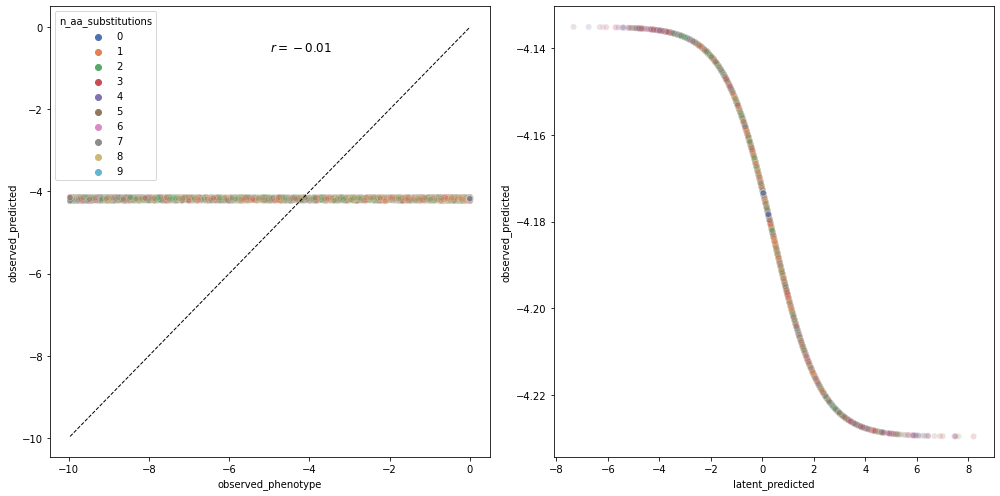

In [23]:


plt.figure(figsize=(14, 7))

plt.subplot(121)
sns.scatterplot(data=updated_sim_func_score_df, x="observed_phenotype", y="observed_predicted",
                hue="n_aa_substitutions",
                alpha=0.2, palette="deep")
lb = updated_sim_func_score_df[["observed_phenotype", "observed_predicted"]].min().min()
ub = updated_sim_func_score_df[["observed_phenotype", "observed_predicted"]].max().max()
plt.plot([lb, ub], [lb, ub], "k--", lw=1)
r = pearsonr(updated_sim_func_score_df.observed_phenotype, updated_sim_func_score_df.observed_predicted)[0]
plt.annotate(f"$r = {r:.2f}$", (.5, .9), xycoords="axes fraction", fontsize=12)

plt.subplot(122)
sns.scatterplot(data=updated_sim_func_score_df, x="latent_predicted", y="observed_predicted",
                hue="n_aa_substitutions",
                alpha=0.2, palette="deep",
                legend=False)
# ϕ_grid = onp.linspace(1.1 * updated_sim_func_score_df.latent_predicted.min(), 1.1 * updated_sim_func_score_df.latent_predicted.max())
# plt.plot(ϕ_grid, g(ϕ_grid, params["α"]), "k")
# plt.axhline(0, color="k", ls="--", lw=1)
# plt.axvline(0, color="k", ls="--", lw=1)

plt.tight_layout()
plt.show()

## Empirical Data (TODO)